In [1]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def crop(img, ratio):
    h, w = img.shape[0:2]
    w_crop = h * ratio[0] // ratio[1]
    h_crop = w * ratio[1] // ratio[0]
    if w > w_crop:
        beg = (w - w_crop) // 2
        end = w - beg
        img = img[:, beg:end]
    elif h > h_crop:
        beg = (h - h_crop) // 2
        end = h - beg
        img = img[beg:end, :]
    return img


def resize(img, dsize):
    return cv2.resize(img, dsize=dsize, interpolation=cv2.INTER_AREA)


def imread_multiple(filenames, flag, dsize=None):
    imgs = []
    for filename in filenames:
        img = cv2.imread(str(filename), flag)
        if dsize:
            img = crop(img, ratio=dsize)
            img = resize(img, dsize=dsize)
        imgs.append(img)
    return imgs


def imshow_multiple(imgs, title, rows=1, cols=1):
    figure, ax = plt.subplots(nrows=rows, ncols=cols)
    for i, img in enumerate(imgs):
        ax.ravel()[i].imshow(img)
        ax.ravel()[i].set_title(title)
    plt.tight_layout()
    plt.show()

In [3]:
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.data = x
        self.target = y
        self.transform = transform
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.data)

In [4]:
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.data = x
        self.target = y
        self.transform = transform
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.data)


img_dir = Path('images')
benign_dir = img_dir / 'benign'
ihunch_dir = img_dir / 'ihunch'

flag = cv2.IMREAD_GRAYSCALE
dsize = (200, 200)
benigns = imread_multiple(benign_dir.glob('*.jpg'), flag, dsize)
ihunchs = imread_multiple(ihunch_dir.glob('*.jpg'), flag, dsize)

x = benigns + ihunchs
y = [0 for _ in benigns] + [1 for _ in ihunchs]
x_train, x_test, y_train, y_test = train_test_split(x, y)

transform = transforms.Compose([transforms.ToTensor()])
data_train = MyDataset(x_train, y_train, transform)
data_test = MyDataset(x_test, y_test, transform)

train_loader = DataLoader(data_train, batch_size=100)
test_loader = DataLoader(data_test, batch_size=1000)

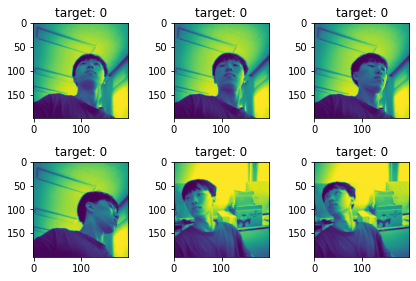

In [5]:
imshow_multiple(benigns[-30:-24], title='target: 0', rows=2, cols=3)

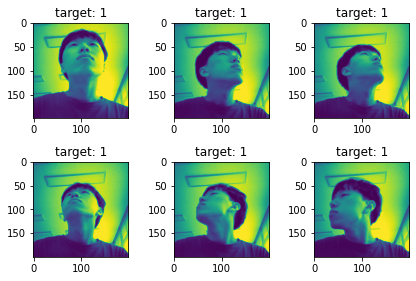

In [6]:
imshow_multiple(ihunchs[-72:-66], title='target: 1', rows=2, cols=3)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            # -> 4@196x196 -> 4@98x98
            nn.Conv2d(1, 4, 5),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # -> 8@96x96 -> 8@48x48
            nn.Conv2d(4, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # -> 12@44x44 -> 12@22x22
            nn.Conv2d(8, 12, 5),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # -> 16@20x20 -> 16@10x10
            nn.Conv2d(12, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(16 * 10 * 10, 200),
            nn.Linear(200, 50),
            nn.Linear(50, 2)
        )
    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print(net)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 12, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Max

In [9]:
%%time
epochs = 15
history = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}

for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0.0
    test_running_loss = 0.0
    test_running_corrects = 0.0
    
    net.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(output, 1)
        running_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == target.data)
    
    with torch.no_grad():
        net.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            loss = criterion(output, target)
            _, preds = torch.max(output, 1)
            test_running_loss += loss.item() * data.size(0)
            test_running_corrects += torch.sum(preds == target.data)
    
    epoch_loss = running_loss / len(train_loader.sampler)
    epoch_acc = running_corrects / len(train_loader.sampler)
    test_epoch_loss = test_running_loss / len(test_loader.sampler)
    test_epoch_acc = test_running_corrects / len(test_loader.sampler)
    print('[%d] loss: %.4f, acc: %.4f, test_loss: %.4f, test_acc: %.4f' % (
            epoch, epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc))

    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)
    history['test_loss'].append(test_epoch_loss)
    history['test_acc'].append(test_epoch_acc)

[1] loss: 0.6489, acc: 0.6309, test_loss: 0.6964, test_acc: 0.5244
[2] loss: 0.4186, acc: 0.8099, test_loss: 0.6114, test_acc: 0.6238
[3] loss: 0.2759, acc: 0.8802, test_loss: 0.3972, test_acc: 0.8246
[4] loss: 0.1938, acc: 0.9251, test_loss: 0.2905, test_acc: 0.8908
[5] loss: 0.1321, acc: 0.9564, test_loss: 0.2754, test_acc: 0.8967
[6] loss: 0.0907, acc: 0.9681, test_loss: 0.3392, test_acc: 0.8928
[7] loss: 0.0751, acc: 0.9779, test_loss: 0.3734, test_acc: 0.8967
[8] loss: 0.0507, acc: 0.9785, test_loss: 0.2846, test_acc: 0.9162
[9] loss: 0.0272, acc: 0.9909, test_loss: 0.3817, test_acc: 0.8967
[10] loss: 0.1231, acc: 0.9486, test_loss: 0.3794, test_acc: 0.8947
[11] loss: 0.1272, acc: 0.9557, test_loss: 0.3772, test_acc: 0.8908
[12] loss: 0.0610, acc: 0.9779, test_loss: 0.2929, test_acc: 0.9123
[13] loss: 0.0553, acc: 0.9805, test_loss: 0.2924, test_acc: 0.9279
[14] loss: 0.0161, acc: 0.9948, test_loss: 0.2785, test_acc: 0.9357
[15] loss: 0.0046, acc: 1.0000, test_loss: 0.2625, test_a

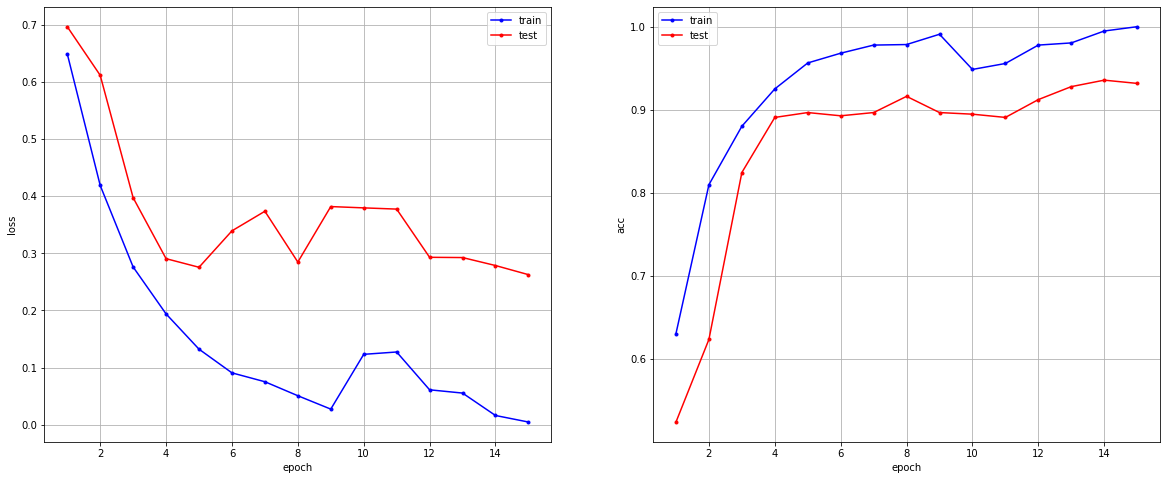

In [11]:
plt.rcParams['figure.figsize'] = [20.0, 8.0]
history_range = np.arange(1, epochs + 1)
fig = plt.figure()
for i, s in enumerate(('loss', 'acc'), 1):
    plt.subplot(1, 2, i)
    plt.plot(history_range, history[s], marker='.', c='blue', label='train')
    plt.plot(history_range, history['test_' + s], marker='.', c='red', label='test')
    plt.legend()
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel(s)
plt.show()